In [4]:
import os

import gpr
import cfGPR
import vonkarman as vk
import treecorr

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import scipy.optimize as opt

Length  4825
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Length  4825
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Mean of first 40 points (Emode (Observed)):  343.2078312186272
Mean of first 40 points (Emode (2 Kernel)):  62.10526040096254
Mean of first 40 points (Emode (von Karman)):  76.84275579394611
Ratio of E modes (Observed / 2 Kernel): 5.526228036124746
Ratio of E modes (Observed / von Karman): 4.4663654715733925
Standard Deviation of first 40 points (Emode (Observed)):  81.03555128084861
Standard Deviation of first 40 points (Emode (2 Kernel)):  40.50047670174439
Standard Deviation of first 40 points (Emode (von Karman)):  36.70039157136756


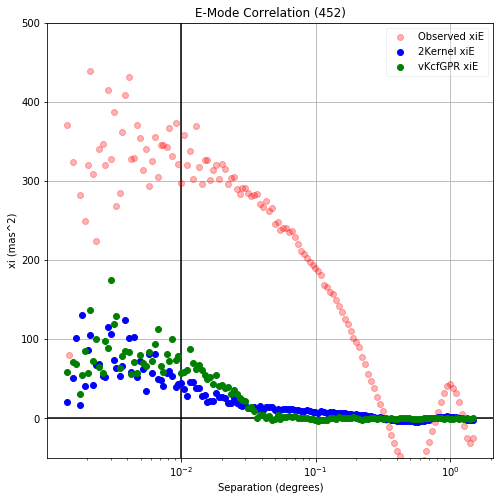

Mean of first 40 points (Bmode (Observed)):  -11.308716613701913
Mean of first 40 points (Bmode (2 Kernel)):  15.26387459090488
Mean of first 40 points (Bmode (von Karman)):  2.743076170329792
Ratio of B modes (Observed / 2 Kernel): -0.7408811272886319
Ratio of B modes (Observed / von Karman): -4.122640390384165
Standard Deviation of first 40 points (Bmode (Observed)):  74.80908643761838
Standard Deviation of first 40 points (Bmode (2 Kernel)):  19.764374602871822
Standard Deviation of first 40 points (Bmode (von Karman)):  21.93779938090394


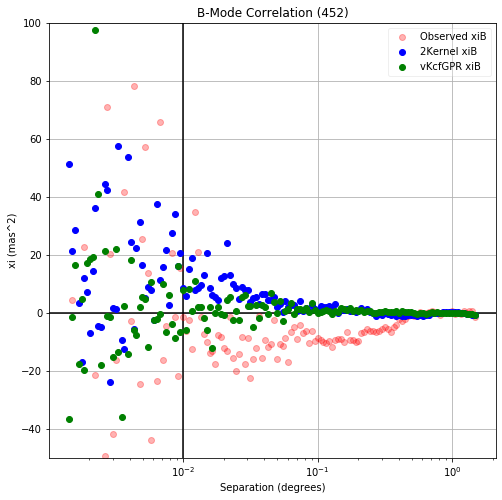

In [10]:
# Try 450, 451, 452, 465
exposure = 452

# Load cfGPR data
cfGPR_data = np.load(f'../vkexposures/{exposure}/{exposure}.npz')

# Solve for weighted and pixelized residuals, as well as angle averaged correlation function.
u, v = cfGPR_data['Xtest'][:, 0], cfGPR_data['Xtest'][:, 1]
dx, dy = cfGPR_data['Ytest'][:, 0] - cfGPR_data['fbar_s'][:, 0], cfGPR_data['Ytest'][:, 1] - cfGPR_data['fbar_s'][:, 1]
logr2, xiplus2, ximinus2, xicross2, xiz22 = cfGPR.vcorr(u, v, dx, dy)

# Calculate xiE and xiB
dlogr2 = np.zeros_like(logr2)
dlogr2[1:-1] = 0.5 * (logr2[2:] - logr2[:-2])
tmp2 = np.array(ximinus2) * dlogr2
integral2 = np.cumsum(tmp2[::-1])[::-1]
xiB2 = 0.5 * (xiplus2 - ximinus2) + integral2
xiE2 = xiplus2 - xiB2

# Load GPR data
GP = gpr.GPR('dxdy', npz=f"../exposures/{exposure}.npz")
GP.savefits('../exposures')
GP.loadfits(f'../exposures/GP{exposure}.fits', f'../exposures/{exposure}.fits')
GP.calc_EB()

# assert np.all(logr2 == GP.logr)

ind = np.sum(GP.r <= 0.01)


E_avg_obs = np.nanmean(GP.xiE[:ind])
E_avg_2k = np.nanmean(GP.GPxiE[:ind])
E_avg_vk = np.nanmean(xiE2[:ind])

E_std_obs = np.nanstd(GP.xiE[:ind])
E_std_2k = np.nanstd(GP.GPxiE[:ind])
E_std_vk = np.nanstd(xiE2[:ind])

f, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 8))
plt.subplots_adjust(wspace=0)

ax.set_title(f"E-Mode Correlation ({exposure})")
ax.axhline(y=0, c='k')
ax.axvline(x=0.01, c='k')

ax.semilogx(GP.r, GP.xiE, 'ro', alpha=0.3, label='Observed xiE')
ax.semilogx(GP.r, GP.GPxiE, 'bo', label='2Kernel xiE')
ax.semilogx(GP.r, xiE2, 'go', label='vKcfGPR xiE')


ax.grid()
ax.set_xlabel('Separation (degrees)')
ax.set_ylabel('xi (mas^2)')

ax.set_ylim((-50, 500))

ax.legend(framealpha=0.3)

print(f"Mean of first {ind+1} points (Emode (Observed)): ", E_avg_obs)
print(f"Mean of first {ind+1} points (Emode (2 Kernel)): ", E_avg_2k)
print(f"Mean of first {ind+1} points (Emode (von Karman)): ", E_avg_vk)

print(f"Ratio of E modes (Observed / 2 Kernel): {E_avg_obs / E_avg_2k}")
print(f"Ratio of E modes (Observed / von Karman): {E_avg_obs / E_avg_vk}")

print(f"Standard Deviation of first {ind+1} points (Emode (Observed)): ", E_std_obs)
print(f"Standard Deviation of first {ind+1} points (Emode (2 Kernel)): ", E_std_2k)
print(f"Standard Deviation of first {ind+1} points (Emode (von Karman)): ", E_std_vk)

plt.show()


B_avg_obs = np.nanmean(GP.xiB[:ind])
B_avg_2k = np.nanmean(GP.GPxiB[:ind])
B_avg_vk = np.nanmean(xiB2[:ind])

B_std_obs = np.nanstd(GP.xiB[:ind])
B_std_2k = np.nanstd(GP.GPxiB[:ind])
B_std_vk = np.nanstd(xiB2[:ind])

f, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 8))
plt.subplots_adjust(wspace=0)

ax.set_title(f"B-Mode Correlation ({exposure})")
ax.axhline(y=0, c='k')
ax.axvline(x=0.01, c='k')

ax.semilogx(GP.r, GP.xiB, 'ro', alpha=0.3, label='Observed xiB')
ax.semilogx(GP.r, GP.GPxiB, 'bo', label='2Kernel xiB')
ax.semilogx(GP.r, xiB2, 'go', label='vKcfGPR xiB')


ax.grid()
ax.set_xlabel('Separation (degrees)')
ax.set_ylabel('xi (mas^2)')

ax.set_ylim((-50, 100))

ax.legend(framealpha=0.3)

print(f"Mean of first {ind+1} points (Bmode (Observed)): ", B_avg_obs)
print(f"Mean of first {ind+1} points (Bmode (2 Kernel)): ", B_avg_2k)
print(f"Mean of first {ind+1} points (Bmode (von Karman)): ", B_avg_vk)

print(f"Ratio of B modes (Observed / 2 Kernel): {B_avg_obs / B_avg_2k}")
print(f"Ratio of B modes (Observed / von Karman): {B_avg_obs / B_avg_vk}")

print(f"Standard Deviation of first {ind+1} points (Bmode (Observed)): ", B_std_obs)
print(f"Standard Deviation of first {ind+1} points (Bmode (2 Kernel)): ", B_std_2k)
print(f"Standard Deviation of first {ind+1} points (Bmode (von Karman)): ", B_std_vk)

plt.show()

> For some exposure, look at the u and v kernel from the 2 Kernel method and compare them to the Cuu and Cuv kernels from the von Karman method

> Use the von Karman covariance function to make a 2 Kernel model. Use the Cuu part to make a kernel for u, and use the Cvv part to make a kernel for v.

> Fit von Karman with a big window (30 arcmin or so) and see what happens.

> Two Layers: Fit a von karman with a big window (30 arcmin or so?); this should pay attention to the outer structure. Subtract that from the correlation function (that you just fitted). Then, fit the residuals with another von Karman (on a smaller scale (5 arcmin or so). When applying this to the GPR algorithm, K_big + K_small and Ks_big and Ks_small should just add together since they should be uncorrelated if they are from different turbulent layers.

> Use the von Karman covariance function to make simulated data (draw from a Guassian with a von Karman covariance function with known parameters). Use this to check that it is doing what we want it to do.

> Try just flipping the sign of the uv term in the covariance matrix because, who knows, maybe somewhere along the way we made a mistake.

> Code in an alert if an optimizer seemed to get stuck at a bound